## **0. 루브릭**

| 평가문항                                                                 | 상세기준                                                                |
|--------------------------------------------------------------------------|-------------------------------------------------------------------------|
| 1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다. | 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다. |
| 2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.           | 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.         |
| 3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 추출되는 OCR이 End-to-End로 구성되었다. | 샘플 이미지들 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.       |


## **1. 실험하기**

In [1]:
# keras_ocr 설치하기
!pip install keras-ocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 253.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [2]:
# LMDB(Lightning Memory-Mapped Database) 설치하기
!pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.2 MB/s eta 0:00:00


In [3]:
# google drive 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **라이브러리 불러오기**

In [4]:
# 라이브러리 불러오기
import re
import six
import math
import lmdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import keras_ocr
from keras_ocr.detection import Detector

In [5]:
# 배치 사이즈 설정하기
BATCH_SIZE = 128

In [6]:
# 데이터 경로 설정하기
TRAIN_DATA_PATH = '/content/drive/MyDrive/07. GoData/02. MJ/MJ/MJ_train'
VALID_DATA_PATH = '/content/drive/MyDrive/07. GoData/02. MJ/MJ/MJ_valid'
TEST_DATA_PATH = '/content/drive/MyDrive/07. GoData/02. MJ/MJ/MJ_test'

### **Input Image**

lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지,

이미지나 라벨은 어떻게 달려 있는지 확인해 보도록 합시다.

━━━━━━━━ 1 ━━━━━━━━
original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


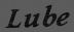

━━━━━━━━ 2 ━━━━━━━━
original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


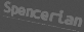

━━━━━━━━ 3 ━━━━━━━━
original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


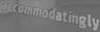

━━━━━━━━ 4 ━━━━━━━━
original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


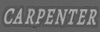

In [7]:
# lmdb에서 데이터를 불러올 때
# env라는 변수명을 사용하는게 일반적임
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 열기
# 이제 txn변수를 통해 직접 데이터에 접근하기
with env.begin(write=False) as txn:
    for index in range(1, 5):
        print(f"━━━━━━━━ {index} ━━━━━━━━")

        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어오기
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요하기
        try:
            img = Image.open(buf).convert('RGB')
        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력하기
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        # 이미지 비율을 유지하면서 높이를 32로 바꾸기
        # 하지만 너비를 100보다는 작게 하고 싶음
        target_width = min(int(width * 32 / height), 100)
        target_img_size = (target_width, 32)
        print('target_img_size:{}'.format(target_img_size))

        # 이미지 크기를 조정하고 numpy array로 변환한 후 transpose 하기
        img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력하기
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1, 0, 2).astype(np.uint8)))

대부분의 이미지의 height는 31, 최대 32까지로 되어 있고, width는 문자열 길이에 따라 다양한 것으로 보입니다.

lmdb를 활용하여 케라스 모델 학습용 MJSynth 데이터셋 클래스를 구현하겠습니다.

In [8]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해두기
    # 또, lmdb에 있는 데이터 수를 미리 파악하기
    def __init__(self,
                dataset_path,     # 데이터셋 경로
                label_converter,  # 라벨을 인덱스로 변환하는 컨버터
                batch_size=1,     # 배치 사이즈
                img_size=(100, 32), # 입력 이미지 크기 (width, height)
                max_text_len=22,  # 최대 텍스트 길이
                is_train=False,   # 훈련 모드 여부
                character=''):    # 학습할 문자 집합

        # 전달받은 매개변수를 멤버 변수로 저장하기
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        # lmdb 환경 설정 및 데이터베이스 열기
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False,
                             readahead=False, meminit=False)

        # 데이터베이스 내의 총 샘플 수를 파악하고, 인덱스 리스트 생성하기
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))  # 총 샘플 수 불러오기
            # 1부터 num_samples까지의 인덱스 리스트 생성
            self.index_list = [index + 1 for index in range(self.num_samples)]

    # 시퀀스의 총 길이 반환하기
    def __len__(self):
        return math.ceil(self.num_samples / self.batch_size / self.divide_length)

    # 주어진 인덱스에 해당하는 이미지와 라벨을 가져오는 메서드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            # 인덱스를 사용하여 라벨 키와 이미지 키 생성하기
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')  # 라벨 가져오기
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)  # 이미지 버퍼 가져오기

            # 이미지 버퍼를 BytesIO 객체로 변환하기
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')  # 이미지를 RGB 모드로 열기
            except IOError:
                img = Image.new('RGB', self.img_size)  # 오류 발생 시 기본 이미지 생성하기
                label = '-'

            # 이미지 크기 조정하기
            width, height = img.size
            target_width = min(int(width * self.img_size[1] / height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)

            # 라벨 정제하기 (대문자로 변환 및 허용되지 않는 문자 제거)
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)

    # 주어진 배치 인덱스에 해당하는 데이터를 가져오는 메서드
    def __getitem__(self, idx):
        # 배치에 해당하는 인덱스 리스트 가져오기
        batch_indices = self.index_list[
            idx * self.batch_size:
            (idx + 1) * self.batch_size
        ]

        # 배치 데이터를 저장할 배열 초기화하기
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')
        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 배치에 해당하는 각 데이터 가져오기
        for i, index in enumerate(batch_indices):
            img, label = self._get_img_label(index)  # 이미지와 라벨 가져오기
            encoded_label = self.label_converter.encode(label)  # 라벨을 인코딩하기

            # 인코딩된 라벨의 길이가 max_text_len을 초과하면 생략하기
            if len(encoded_label) > self.max_text_len:
                continue

            # 이미지와 라벨을 배치 데이터에 저장하기
            width = img.shape[0]
            input_images[i, :width, :, :] = img
            labels[i, 0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        # 모델 입력과 출력을 딕셔너리 형태로 반환하기
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

### **Encode**

각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다.

이를 해줄 수 있는 LabelConverter 클래스를 작성해 봅시다.

In [9]:
class LabelConverter(object):
    # 입력으로 받은 text를 self.dict에
    # 각 character 들이 어떤 index 에 매핑되는지 저장하기
    def __init__(self, character):
        # 첫 번째 문자는 공백 문자를 나타내는 '-'로 설정하기
        self.character = "-" + character
        # 문자와 인덱스를 매핑하는 딕셔너리 초기화하기
        self.label_map = dict()
        for i, char in enumerate(self.character):
            # 각 문자를 인덱스로 매핑하여 딕셔너리에 저장하기
            self.label_map[char] = i

    # character -> index 변환하기
    # cf. 공백 문자를 뜻하는 '-' 의 label 은 0 으로 지정
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                # 같은 문자 사이에 공백(blank) 문자 label을 삽입하기
                encoded_label.append(0)
            # 문자를 인덱스로 변환하여 추가하기
            encoded_label.append(self.label_map[char])

        # 인코딩된 라벨을 반환하기
        return np.array(encoded_label)

    # index -> character 변환하기
    # => 사람이 읽을 수 있는 text 로 변경하기
    def decode(self, encoded_label):
        target_characters = list(self.character)  # 문자의 리스트 만들기
        decoded_label = ""
        for encode in encoded_label:
            # 인덱스를 문자로 변환하여 추가하기
            decoded_label += self.character[encode]
        return decoded_label  # 디코딩된 라벨을 반환하기

In [10]:
# 찾아낼 문자 미리 설정하기
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")  # 36

The total number of characters is 36


In [11]:
label_converter = LabelConverter(TARGET_CHARACTERS)

In [12]:
# 인코딩된 텍스트 확인하기
encdoded_text = label_converter.encode('APPLE')
print("Encdoded_text: ", encdoded_text)  # [ 1 16  0 16 12  5]

Encdoded_text:  [ 1 16  0 16 12  5]


In [13]:
# 디코딩된 텍스트 확인하기
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)  # HEL-LO

Decoded_text:  AP-PLE


동일한 글자 'P'가 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있습니다.

### **Build CRNN model**

In [17]:
# CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

`K.ctc_batch_cost()`를 활용하여, `image_input`을 입력으로,

마지막 Label을 `'output'`이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 `build_crnn_model()`을 구현해 봅시다.

In [18]:
# CRNN 모델 구현하기
def build_crnn_model(input_shape=(100, 32, 3), characters=TARGET_CHARACTERS):
    # 캐릭터 집합의 크기와 입력 이미지 크기를 설정하기
    num_chars = len(characters) + 2  # 문자 집합의 크기 (문자 + 공백 + 추가 문자)
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')  # 이미지 입력 레이어

    # Build CRNN model
    # Conv Layers
    # Feature 추출 (Convolutional Layers)
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)

    # 마지막 Convolution Layer로 Feature 추출하기
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    # Recurrent Layers
    # 추출된 Feature의 전체적인 Context 파악 (Recurrent Layers)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)

    # Transcription Layer(=Fully Connected Layer)
    # Step마다 어떤 Character의 확률이 높은지 예측 (Transcription Layer)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # CRNN 모델 생성하기
    labels = layers.Input(shape=[22], dtype='int64', name='label')  # 라벨 입력 레이어
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')  # 입력 길이 레이어
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')  # 라벨 길이 레이어
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )  # CTC 손실 레이어

    # 모델 입력과 출력을 정의하여 모델 구성하기
    model_input = [image_input, labels, input_length, label_length]
    model = Model(inputs=model_input, outputs=loss_out)
    return model  # CRNN 모델 반환하기

### **Train & Inference**

`MJDatasetSequence`로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜봅시다.

In [14]:
# 훈련 데이터셋 분리하기
train_dataset = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE,
                                  character=TARGET_CHARACTERS, is_train=True)

print(f'Train Dataset 개수: {len(train_dataset)}')  # 565

Train Dataset 개수: 565


In [15]:
# 검증 데이터셋 분리하기
valid_dataset = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE,
                                  character=TARGET_CHARACTERS, is_train=False)

print(f'Valid Dataset 개수: {len(valid_dataset)}')  # 63

Valid Dataset 개수: 63


In [16]:
# 테스트 데이터셋 분리하기
test_dataset = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE,
                                 character=TARGET_CHARACTERS, is_train=False)

print(f'Test Dataset 개수: {len(test_dataset)}')  # 70

Test Dataset 개수: 70


In [19]:
# 모델 생성하기
crnn_model = build_crnn_model()

In [20]:
# 모델 요약하기
crnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 100, 32, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 32, 64)          1792      ['input_image[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 50, 16, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 50, 16, 128)          73856     ['max_pooling2d[0][0]']   

In [21]:
# 옵티마이저 설정하기
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)

# 모델 컴파일하기
crnn_model.compile(
    optimizer=optimizer,
    loss={'ctc': lambda y_true, y_pred: y_pred},
    metrics=['accuracy'],
)

In [22]:
# 학습 횟수 설정하기
EPOCHS = 30

In [23]:
# ModelCheckpoint와 EarlyStopping 활용하기
# checkpoint 설정하기
checkpoint_path = '/content/drive/MyDrive/07. GoData/02. MJ/model_checkpoint.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss',
                             save_best_only=True, save_weights_only=True)

# earlystop 설정하기
earlystop = EarlyStopping(monitor='val_loss', patience=7,
                          restore_best_weights=True)

In [24]:
# 모델 학습하기
crnn_history = crnn_model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=EPOCHS,
    validation_data=valid_dataset,
    validation_steps=len(valid_dataset),
    callbacks=[checkpoint, earlystop]
)

Epoch 1/50
565/565 [==============================] - 147s 220ms/step - loss: 25.1709 - accuracy: 0.0000e+00 - val_loss: 24.0272 - val_accuracy: 0.0000e+00
Epoch 2/50
565/565 [==============================] - 113s 200ms/step - loss: 13.5596 - accuracy: 0.0042 - val_loss: 9.6918 - val_accuracy: 0.0228
Epoch 3/50
565/565 [==============================] - 112s 198ms/step - loss: 6.9558 - accuracy: 0.0990 - val_loss: 6.5308 - val_accuracy: 0.1590
Epoch 4/50
565/565 [==============================] - 112s 198ms/step - loss: 5.0972 - accuracy: 0.2516 - val_loss: 5.2894 - val_accuracy: 0.2824
Epoch 5/50
565/565 [==============================] - 112s 198ms/step - loss: 4.0895 - accuracy: 0.3680 - val_loss: 4.7205 - val_accuracy: 0.3470
Epoch 6/50
565/565 [==============================] - 113s 200ms/step - loss: 3.3763 - accuracy: 0.4519 - val_loss: 4.5761 - val_accuracy: 0.3974
Epoch 7/50
565/565 [==============================] - 112s 199ms/step - loss: 2.7991 - accuracy: 0.5201 - val_los

In [29]:
# 학습 결과 시각화하는 함수 구현하기
def draw_unet_history(history, model_name='Recognition_CRNN'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화하기
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화하기
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()

<ipython-input-29-b98553f137a5>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


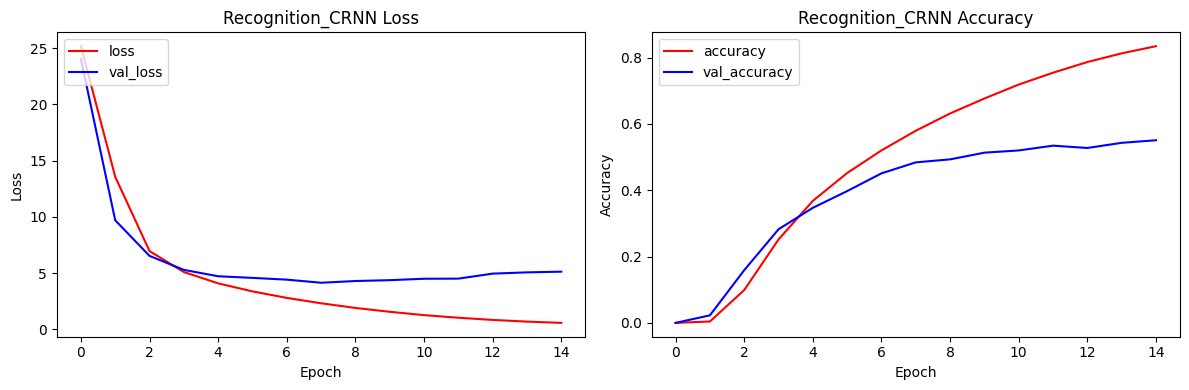

In [30]:
# 학습 결과 시각화하기
draw_unet_history(crnn_history, 'Recognition_CRNN')

**Recognition_CRNN Loss**
* 학습 손실은 지속적으로 감소하여 모델이 학습 데이터를 잘 학습하고 있음을 보여줍니다.
* 검증 손실은 초기에는 급격히 감소하다가 6-7 에포크 이후 안정화됩니다. 이는 모델이 검증 데이터에 대해 잘 일반화되고 있음을 시사하지만, 초기 몇 에포크 이후로는 큰 개선이 없음을 보여줍니다.

**Recognition_CRNN Accuracy**
* 학습 정확도는 지속적으로 증가하여 모델이 학습 데이터에 대해 점점 더 정확한 예측을 하고 있음을 보여줍니다.
* 검증 정확도도 증가하지만, 8 에포크 이후로는 증가 속도가 느려져 약 0.6 수준에서 안정화됩니다. 이는 모델이 처음에는 검증 데이터에 대해 성능이 향상되지만, 이후로는 큰 변화가 없음을 시사합니다.

이제 학습된 모델을 테스트셋을 통해 확인해 볼 차례입니다.

In [33]:
# 모델 아키텍처 정의하기
crnn_model = build_crnn_model()

# 모델의 가중치 불러오기
checkpoint_path = '/content/drive/MyDrive/07. GoData/02. MJ/model_checkpoint.hdf5'
crnn_model.load_weights(checkpoint_path)

# 모델의 가중치 불러오기
crnn_model.load_weights(checkpoint_path)

In [34]:
# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없음.
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들 것임.
# inference 전용 모델임.
input_data = crnn_model.get_layer('input_image').output
y_pred = crnn_model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

학습된 모델의 성능을 눈으로 확인해봅시다.

In [35]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 함
# 코드 하나하나를 이해하기는 조금 어려울 수 있음
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        # 의미없는 인덱스 -1 위치 숫자 9 출력 방지하기
        if index == -1:
            continue
        # 예측한 문자 저장하기
        text += chars[index]
    return text

In [36]:
# 모델과 데이터셋이 주어지면 inference를 수행하기
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해주기
def check_inference(model, dataset, index = 5):
    for i in range(index):
        print(f"━━━━━━━━ {i} ━━━━━━━━")
        inputs, outputs = dataset[i]
        img = inputs['input_image'][0:1,:,:,:]
        output = model.predict(img)  # 모델 예측하기

        # 예측하기
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
        print(f"Result: \t{result}")

        # 라벨 붙이기
        label = ''.join(map(lambda x: label_converter.decode(x), inputs['label'][0:1,])).replace('-','')
        print(f"Label:  \t{label}")

        # 예측, 라벨 인덱스별로 비교해서 같으면 1, 다르면 0 표시하기
        is_right = ''.join(map(lambda x: '1' if x[0] == x[1] else '0', zip(result, label)))
        print(f"Is_Right:\t{is_right}")

        # 맞춘 문자 개수, 점수 계산하기
        is_right_count = is_right.count('1')
        print(f"Is_Right_Count:\t{is_right_count}/{len(label)}")
        print(f"Score: {is_right_count/len(label):.2f}")

        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

━━━━━━━━ 0 ━━━━━━━━
1/1 [==============================] - 2s 2s/step
Result: 	SLINKING
Label:  	SLINKING
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


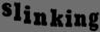

━━━━━━━━ 1 ━━━━━━━━
1/1 [==============================] - 0s 35ms/step
Result: 	ALEPPO
Label:  	ALEPPO
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


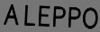

━━━━━━━━ 2 ━━━━━━━━
1/1 [==============================] - 0s 28ms/step
Result: 	IWENDA
Label:  	RWANDA
Is_Right:	010111
Is_Right_Count:	4/6
Score: 0.67


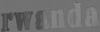

━━━━━━━━ 3 ━━━━━━━━
1/1 [==============================] - 0s 28ms/step
Result: 	NATHANS
Label:  	NATHANS
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


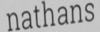

━━━━━━━━ 4 ━━━━━━━━
1/1 [==============================] - 0s 29ms/step
Result: 	HALLZD
Label:  	HALLOO
Is_Right:	111100
Is_Right_Count:	4/6
Score: 0.67


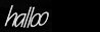

━━━━━━━━ 5 ━━━━━━━━
1/1 [==============================] - 0s 30ms/step
Result: 	HURLS
Label:  	HURLS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


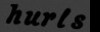

━━━━━━━━ 6 ━━━━━━━━
1/1 [==============================] - 0s 34ms/step
Result: 	DOWNSIZE
Label:  	DOWNSIZE
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


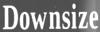

━━━━━━━━ 7 ━━━━━━━━
1/1 [==============================] - 0s 29ms/step
Result: 	ROBOTIC
Label:  	ROBOTIC
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


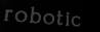

━━━━━━━━ 8 ━━━━━━━━
1/1 [==============================] - 0s 33ms/step
Result: 	STOPPY
Label:  	SLOPPY
Is_Right:	101111
Is_Right_Count:	5/6
Score: 0.83


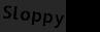

━━━━━━━━ 9 ━━━━━━━━
1/1 [==============================] - 0s 38ms/step
Result: 	HERMITE
Label:  	HERMITE
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


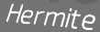

━━━━━━━━ 10 ━━━━━━━━
1/1 [==============================] - 0s 38ms/step
Result: 	DEARS
Label:  	DEARS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


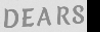

━━━━━━━━ 11 ━━━━━━━━
1/1 [==============================] - 0s 35ms/step
Result: 	POLYSYLABIC
Label:  	POLYSYLLABIC
Is_Right:	11111110000
Is_Right_Count:	7/12
Score: 0.58


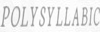

━━━━━━━━ 12 ━━━━━━━━
1/1 [==============================] - 0s 37ms/step
Result: 	DESE
Label:  	DENSE
Is_Right:	1100
Is_Right_Count:	2/5
Score: 0.40


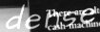

━━━━━━━━ 13 ━━━━━━━━
1/1 [==============================] - 0s 38ms/step
Result: 	DIAERESES
Label:  	DIAERESES
Is_Right:	111111111
Is_Right_Count:	9/9
Score: 1.00


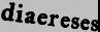

━━━━━━━━ 14 ━━━━━━━━
1/1 [==============================] - 0s 25ms/step
Result: 	HUMPBACKS
Label:  	HUMPBACKS
Is_Right:	111111111
Is_Right_Count:	9/9
Score: 1.00


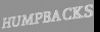

━━━━━━━━ 15 ━━━━━━━━
1/1 [==============================] - 0s 23ms/step
Result: 	MDOPTEDL
Label:  	ADOPTED
Is_Right:	0111111
Is_Right_Count:	6/7
Score: 0.86


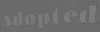

━━━━━━━━ 16 ━━━━━━━━
1/1 [==============================] - 0s 23ms/step
Result: 	MILIWAUKEE
Label:  	MILWAUKEE
Is_Right:	111000001
Is_Right_Count:	4/9
Score: 0.44


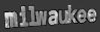

━━━━━━━━ 17 ━━━━━━━━
1/1 [==============================] - 0s 23ms/step
Result: 	SPECIFICATION
Label:  	SPECIFICATION
Is_Right:	1111111111111
Is_Right_Count:	13/13
Score: 1.00


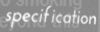

━━━━━━━━ 18 ━━━━━━━━
1/1 [==============================] - 0s 22ms/step
Result: 	REACTIONARY
Label:  	REACTIONARY
Is_Right:	11111111111
Is_Right_Count:	11/11
Score: 1.00


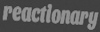

━━━━━━━━ 19 ━━━━━━━━
1/1 [==============================] - 0s 22ms/step
Result: 	OSCEOLA
Label:  	OSCEOLA
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


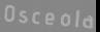

In [37]:
# 결과를 디코딩해 출력해주기
check_inference(model_pred, test_dataset, index=20)

> 대부분 잘 맞추지만, 흐리게 보이거나 뭉게질 경우 이를 잘 보지 못함을 알 수 있습니다.

이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어봅시다.

inference한 후에는 이를 시각화하도록 합니다. 단어의 영역을 잘라오도록 해봅시다.

In [38]:
# 텍스트 탐지 함수 구현하기
def detect_text(img_path, detector):

    # 이미지 불러오기
    img_pil = Image.open(img_path).convert('RGB')  # (1200, 900, 3)

    # 1. Keras-OCR 의 Detection 모델에 입력하기 위한 이미지 전처리하기
    # - 이미지 비율 유지해서 resize() 적용하기
    # - 배치 크기 때문에 4 dims 로 확장하기
    # - shape=(H,W,C) 여야 모델 입력시 제대로 동작함
    width, height = img_pil.size  # 원본 이미지 크기
    # 이미지 비율 유지, 높이 300, 너비는 400 보다 작게 설정하기
    target_width = min(int(width*300/height), 400)
    target_img_size = (target_width,300)

    img_pil = img_pil.resize(target_img_size)  # (400, 300, 3)
    img_pil_copy = img_pil.copy()

    img_pil = np.array(img_pil)  # (300, 400, 3)
    img_pil = np.expand_dims(img_pil, axis=0)  # (1, 300, 400, 3)

    # 2. 모델 예측하기
    # - OCR 텍스트 검출 결과
    # - 배치 첫 번째 결과 가져오기
    detect_result = detector.detect(img_pil)  # 타입: list
    ocr_result = detect_result[0]  # 타입: np.array

    # 3. display() 하기 위한 이미지 전처리하기
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소하기
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    img_pil = np.squeeze(img_pil, axis=0).astype(np.uint8)  # (300, 400, 3)
    img_pil = Image.fromarray(img_pil)
    img_draw = ImageDraw.Draw(img_pil)

    cropped_imgs = []  # 단어 영역
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil_copy.crop(word_box))

    return img_pil, cropped_imgs

Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해봅시다.

In [39]:
# 이미지를 인식하는 함수 구현하기
def recognize_img(idx, pil_img, model_pred, input_img_size=(100,32)):
    # CRNN 기반의 Recognition 모델에 입력하기 위한 이미지 전처리하기
    # - 배치 크기 때문에 4 dims 로 확장하기
    # - shape=(W,H,C) 여야 모델 입력시 제대로 동작함
    pil_img = pil_img.resize(input_img_size)  # (100, 32, 3)
    pil_img = np.array(pil_img)  # (32, 100, 3)
    pil_img = pil_img.transpose(1,0,2)  # (100, 32, 3)
    pil_img = np.expand_dims(pil_img, axis=0)  # (1, 100, 32, 3)

    # 모델 예측하기
    # - OCR 텍스트 인식 결과 출력하기
    output = model_pred.predict(pil_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
    print("Result: \t", result)

    # display() 하기 위한 이미지 전처리하기
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소하기
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    pil_img = np.squeeze(pil_img, axis=0).transpose(1,0,2).astype(np.uint8)  # (32, 100, 3)
    pil_img = Image.fromarray(pil_img)
    display(pil_img)

In [40]:
# END-TO-END OCR 함수 구현하기
def end_to_end_ocr(img_path, detector, model_pred):
    # Text Detection
    print('━━━━━━━━ Text Detection ━━━━━━━━')
    img_pil, cropped_img = detect_text(img_path, detector)
    display(img_pil)

    # Text Recognition
    print('━━━━━━━━ Text Recognition ━━━━━━━━')
    for idx, _img in enumerate(cropped_img):
        recognize_img(idx, _img, model_pred)

In [41]:
# 샘플 이미지 불러오기
SAMPLE_IMG_PATH = '/content/drive/MyDrive/07. GoData/02. MJ/sleeper.jpg'

In [42]:
# Detector 모델 사용하기
detector = Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


━━━━━━━━ Text Detection ━━━━━━━━
1/1 [==============================] - 0s 39ms/step


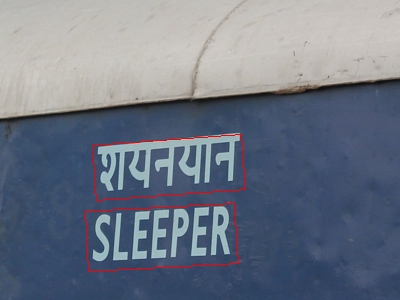

━━━━━━━━ Text Recognition ━━━━━━━━
1/1 [==============================] - 0s 33ms/step
Result: 	 RERIAL


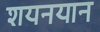

1/1 [==============================] - 0s 24ms/step
Result: 	 ISLEEPER


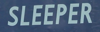

In [44]:
# 결과 확인하기
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

## **2. 회고하기**

**[배운 점 & 느낀 점]** 실생활에서 자주 사용하는 OCR 기술에 대해서 공부해봤는데, 지금까지 배웠던 기술을 총집합해 적용한 기술이라 신기했다. 특히 OCR이 단순히 text detection만 수행하는 것이 아닌, 글자의 문맥도 읽어야 한다는 사실을 배웠다. 모델 학습 후 End-to-End로 OCR 기술을 적용해봤는데, 결과가 어느 정도 잘 나와서 좋았다. 그리고 힌두교도 비슷한 알파벳으로 변형되는 것 또한 신기했다.

**[아쉬운 점 & 어려웠던 점]** 앞서 언급했다시피 이번 OCR 기술이 지금까지 배웠던 모든 모델의 특징을 복합적으로 섞어놓은 기술이라서 이를 이해하기 굉장히 어려웠다. 처음에는 실생활에서 자주 쓰이는 기술이라 만만히 봤지만, 하나하나 다 배우다보니 따라가지 못해서 아쉬웠다. 이후에 다시 복습을 해야겠다.